# Notebook 5: Comparativa con Benchmarks y Métricas

## Objetivo
Análisis completo de resultados del backtesting, comparación con benchmarks (SPY y Monte Carlo), cálculo de métricas financieras y análisis crítico de la estrategia.

## Metodología
Este notebook implementa un test de Monte Carlo altamente eficiente para validar la robustez de la estrategia mediante comparación con carteras aleatorias. La implementación utiliza técnicas de vectorización avanzadas para procesar millones de simulaciones en tiempo razonable:
- **Vectorización completa**: Uso de operaciones vectorizadas con `np.argsort` y `np.argpartition` para eliminar loops internos
- **Procesamiento por batches**: Procesamiento en batches grandes (250,000 simulaciones) para optimizar memoria y velocidad
- **Generador RNG eficiente**: Uso de `np.random.default_rng()` para mejor rendimiento en generación de números aleatorios
- **Optimización de memoria**: Acumulación directa sin arrays 3D intermedios para reducir uso de memoria

## Contenido
1. Carga de resultados y benchmark SPY
2. Cálculo de métricas financieras (CAGR, Sharpe, Sortino, Max Drawdown, Beta, Alpha)
3. Visualizaciones requeridas
4. Test de Monte Carlo vectorizado (≥25 millones de carteras aleatorias con eligibility mask)
5. Análisis crítico final (sesgos, robustez, realismo)

## Índice
1. [Configuración y Carga de Resultados](#configuracion)
2. [Carga del Benchmark SPY](#benchmark-spy)
3. [Cálculo de Métricas Financieras](#metricas)
4. [Visualizaciones](#visualizaciones)
5. [Test de Monte Carlo Vectorizado](#monte-carlo)
6. [Análisis Crítico Final](#analisis-critico)

---

## 1. Configuración y Carga de Resultados {#configuracion}

Esta sección configura el entorno, importa las librerías necesarias y carga los resultados del backtesting del Notebook 4.

**Decisiones clave:**
- **Carga de equity curve y trades**: Se cargan los resultados del backtesting (equity curve y trades) generados en el Notebook 4 para análisis posterior.
- **Formato parquet para equity**: Se usa formato parquet por eficiencia de lectura, especialmente importante para análisis de series temporales largas.
- **Cálculo de retornos**: Se calculan retornos mensuales a partir de la equity curve para cálculo de métricas financieras.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from scipy import stats

# Configuración
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Parámetros
CAPITAL_INICIAL = 250_000
DATA_BACKTEST_DIR = '../datos/backtest'
DATA_PROCESSED_DIR = '../datos/processed'

print("="*70)
print("NOTEBOOK 5: COMPARATIVA (VERSIÓN OPTIMIZADA)")
print("="*70)

# Cargar resultados del backtesting
df_equity = pd.read_parquet(f'{DATA_BACKTEST_DIR}/equity_curve.parquet')
df_trades = pd.read_csv(f'{DATA_BACKTEST_DIR}/trades.csv', parse_dates=['fecha'])

# Convertir fecha a índice para análisis temporal
df_equity['fecha'] = pd.to_datetime(df_equity['fecha'])
df_equity = df_equity.set_index('fecha').sort_index()

# Calcular retornos mensuales
df_equity['retorno_mensual'] = df_equity['equity'].pct_change()

print(f"\nEquity curve: {df_equity.shape}")
print(f"Trades: {df_trades.shape}")
print(f"Período: {df_equity.index[0].date()} a {df_equity.index[-1].date()}")
print(f"Capital inicial: ${CAPITAL_INICIAL:,.0f}")
print(f"Capital final: ${df_equity['equity'].iloc[-1]:,.0f}")
print(f"Retorno total: {(df_equity['equity'].iloc[-1] / CAPITAL_INICIAL - 1) * 100:.2f}%")

NOTEBOOK 5: COMPARATIVA (VERSIÓN OPTIMIZADA)

Equity curve: (133, 4)
Trades: (3372, 8)
Período: 2015-01-30 a 2026-01-30
Capital inicial: $250,000
Capital final: $780,904
Retorno total: 212.36%


## 2. Carga del Benchmark SPY {#benchmark-spy}

Esta sección carga los datos del benchmark SPY procesados en el Notebook 2 para comparación con la estrategia.

**Decisiones clave:**
- **Uso de datos procesados**: Se cargan los datos de SPY ya procesados del Notebook 2 (precios mensuales y retornos logarítmicos) para mantener consistencia en el pipeline.
- **Alineación temporal**: Se alinean los datos de SPY con las fechas de rebalanceo de la estrategia para comparación justa.
- **Cálculo de equity curve**: Se construye la equity curve de SPY con el mismo capital inicial para comparación directa.

In [5]:
# Cargar datos de SPY procesados
spy_prices = pd.read_parquet(f'{DATA_PROCESSED_DIR}/spy_prices_monthly.parquet')
spy_log_returns = pd.read_parquet(f'{DATA_PROCESSED_DIR}/spy_log_returns_monthly.parquet')

# Alinear con fechas de rebalanceo
spy_aligned = spy_prices.reindex(df_equity.index, method='ffill')
spy_returns_aligned = spy_log_returns.reindex(df_equity.index, method='ffill')

# Construir equity curve de SPY
spy_equity = CAPITAL_INICIAL * np.exp(spy_returns_aligned['SPY'].cumsum())
spy_equity = spy_equity.fillna(CAPITAL_INICIAL)

# Calcular retornos mensuales de SPY
spy_retorno_mensual = spy_returns_aligned['SPY']

print(f"SPY equity curve: {len(spy_equity)} fechas")
print(f"SPY capital final: ${spy_equity.iloc[-1]:,.0f}")
print(f"SPY retorno total: {(spy_equity.iloc[-1] / CAPITAL_INICIAL - 1) * 100:.2f}%")

SPY equity curve: 133 fechas
SPY capital final: $1,044,491
SPY retorno total: 317.80%


## 3. Cálculo de Métricas Financieras {#metricas}

Esta sección calcula todas las métricas financieras requeridas para evaluar el desempeño de la estrategia.

**Decisiones clave:**
- **CAGR**: Se calcula usando retorno total y número de años, proporcionando una métrica anualizada estándar para comparación.
- **Volatilidad anualizada**: Se anualiza multiplicando por √12 (12 meses) para retornos mensuales, permitiendo comparación con benchmarks anuales.
- **Sharpe y Sortino**: Se calculan usando tasa libre de riesgo (2% anual), con Sortino penalizando solo volatilidad negativa (más apropiado para estrategias asimétricas).
- **Beta y Alpha**: Se calculan usando regresión contra SPY para medir exposición sistemática y retorno exceso ajustado por riesgo.

In [6]:
def calcular_metricas(equity_curve, retornos_mensuales, benchmark_equity=None, benchmark_returns=None, risk_free_rate=0.02):
    """
    Calcula métricas financieras completas.
    
    Parameters
    ----------
    equity_curve : pd.Series
        Serie temporal del valor de la cartera
    retornos_mensuales : pd.Series
        Retornos mensuales
    benchmark_equity : pd.Series, optional
        Equity curve del benchmark
    benchmark_returns : pd.Series, optional
        Retornos mensuales del benchmark
    risk_free_rate : float
        Tasa libre de riesgo anual (default: 2%)
    
    Returns
    -------
    dict
        Diccionario con todas las métricas
    """
    metrics = {}
    
    # Filtrar NaN
    retornos = retornos_mensuales.dropna()
    
    # 1. CAGR
    años = (equity_curve.index[-1] - equity_curve.index[0]).days / 365.25
    total_return = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    metrics['CAGR'] = ((1 + total_return) ** (1 / años) - 1) * 100 if años > 0 else 0
    
    # 2. Volatilidad (anualizada para retornos mensuales)
    metrics['Volatilidad'] = retornos.std() * np.sqrt(12) * 100
    
    # 3. Ratio Sharpe (anualizado)
    excess_returns = retornos - (risk_free_rate / 12)
    sharpe_ratio = excess_returns.mean() / retornos.std() * np.sqrt(12) if retornos.std() > 0 else 0
    metrics['Sharpe'] = sharpe_ratio
    
    # 4. Ratio Sortino (solo penaliza volatilidad negativa)
    negative_returns = retornos[retornos < 0]
    downside_std = negative_returns.std() * np.sqrt(12) if len(negative_returns) > 0 else 0
    sortino_ratio = excess_returns.mean() / downside_std * np.sqrt(12) if downside_std > 0 else 0
    metrics['Sortino'] = sortino_ratio
    
    # 5. Máximo Drawdown
    cumulative = (1 + retornos).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    metrics['Max_Drawdown'] = drawdown.min() * 100
    
    # 6. Beta y Alpha (si hay benchmark)
    if benchmark_equity is not None and benchmark_returns is not None:
        bench_returns = benchmark_returns.dropna()
        
        # Alinear fechas
        common_dates = retornos.index.intersection(bench_returns.index)
        if len(common_dates) > 0:
            algo_ret = retornos.loc[common_dates]
            bench_ret = bench_returns.loc[common_dates]
            
            # Beta: covarianza / varianza del benchmark
            covariance = np.cov(algo_ret, bench_ret)[0, 1]
            benchmark_variance = np.var(bench_ret)
            beta = covariance / benchmark_variance if benchmark_variance > 0 else 0
            metrics['Beta'] = beta
            
            # Alpha: retorno exceso sobre CAPM
            expected_return = risk_free_rate / 12 + beta * (bench_ret.mean() * 12 - risk_free_rate)
            actual_return = algo_ret.mean() * 12
            alpha = (actual_return - expected_return) * 100
            metrics['Alpha'] = alpha
        else:
            metrics['Beta'] = np.nan
            metrics['Alpha'] = np.nan
    else:
        metrics['Beta'] = np.nan
        metrics['Alpha'] = np.nan
    
    return metrics


# Calcular métricas para estrategia
algo_metrics = calcular_metricas(
    df_equity['equity'],
    df_equity['retorno_mensual'],
    spy_equity,
    spy_retorno_mensual
)

# Calcular métricas para SPY
spy_metrics = calcular_metricas(
    spy_equity,
    spy_retorno_mensual,
    spy_equity,
    spy_retorno_mensual
)

# Crear tabla comparativa
comparison_table = pd.DataFrame({
    'Estrategia': algo_metrics,
    'SPY': spy_metrics
}).T

print("\n" + "="*70)
print("TABLA COMPARATIVA DE MÉTRICAS")
print("="*70)
print(comparison_table.round(2))


TABLA COMPARATIVA DE MÉTRICAS
             CAGR  Volatilidad  Sharpe  Sortino  Max_Drawdown  Beta  Alpha
Estrategia  10.93        20.61    0.51     0.21        -32.54  1.10   0.29
SPY         13.88        14.90    0.74     0.29        -25.48  1.01   1.75


## 4. Visualizaciones {#visualizaciones}

Visualizaciones requeridas para análisis de desempeño y comparación con benchmark.

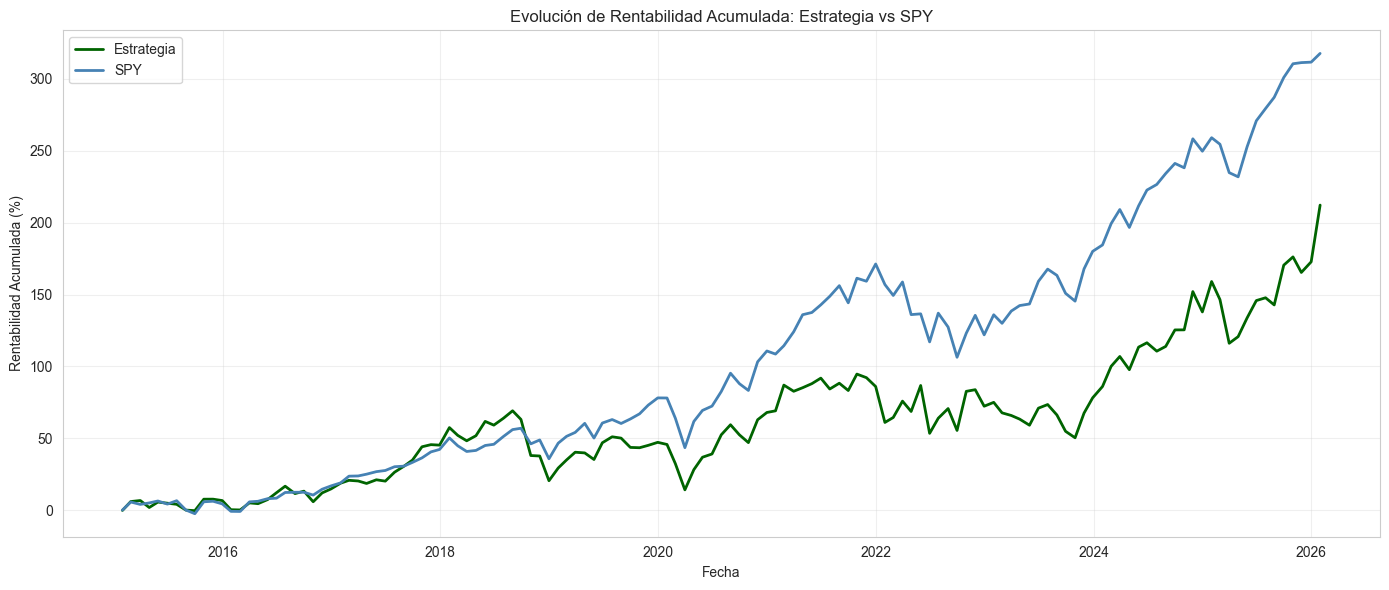

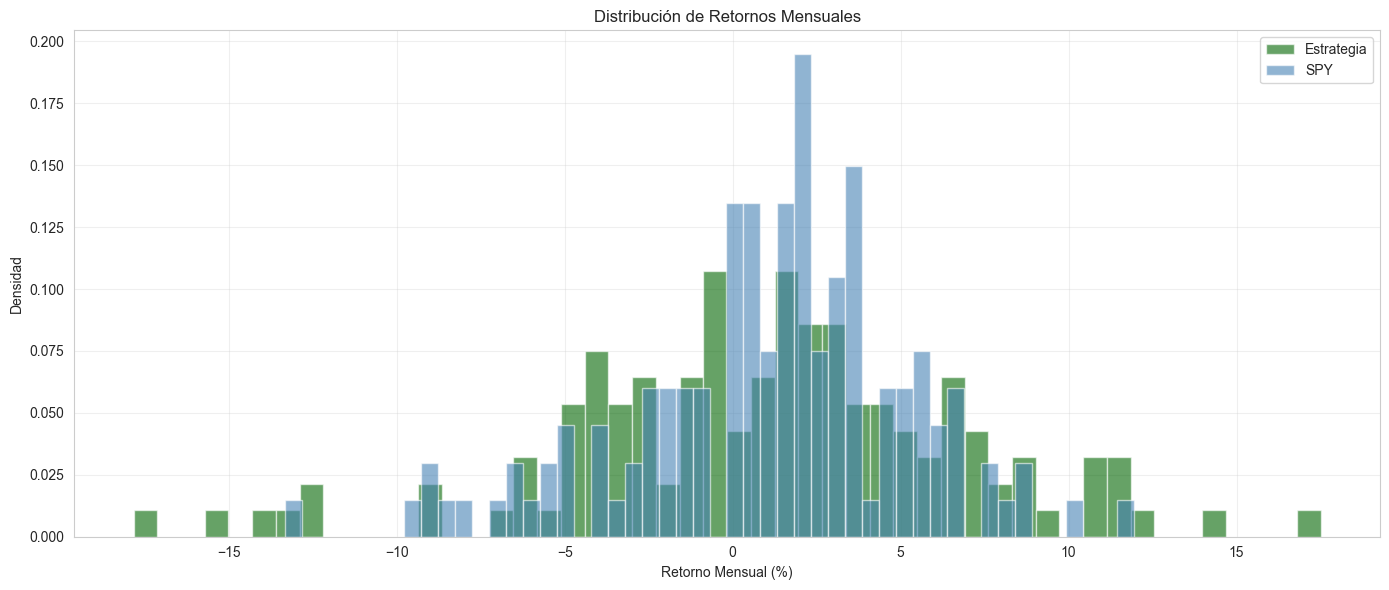

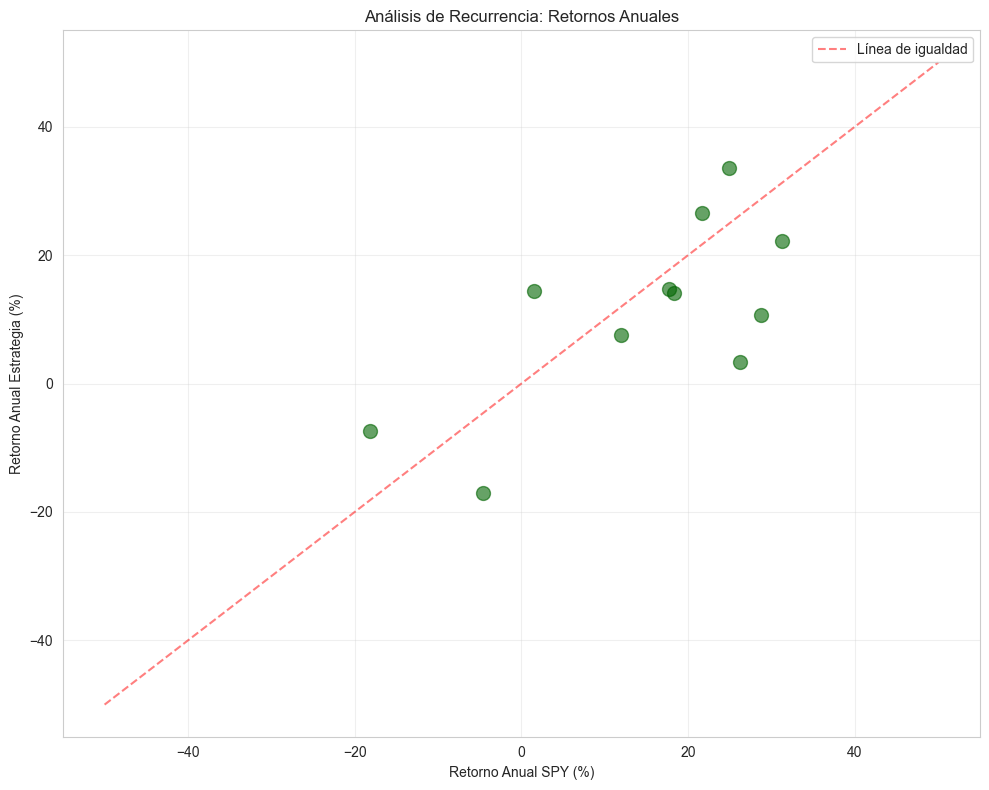

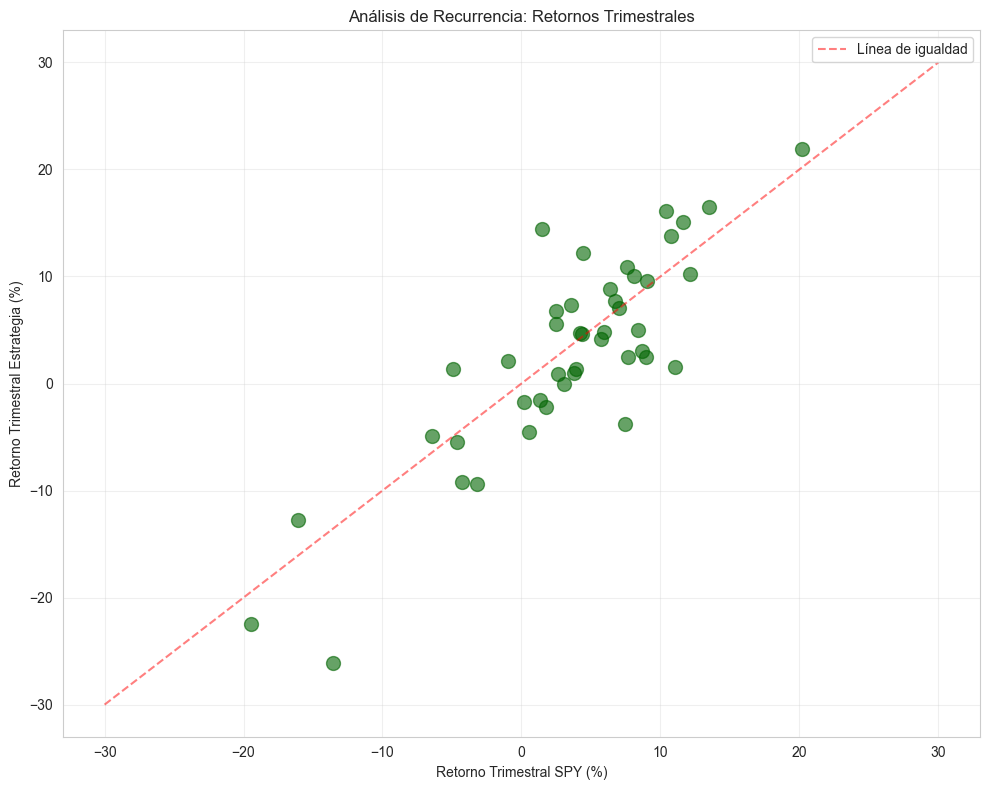

In [7]:
# 1. Evolución de rentabilidad acumulada (%)
algo_returns_pct = (df_equity['equity'] / CAPITAL_INICIAL - 1) * 100
spy_returns_pct = (spy_equity / CAPITAL_INICIAL - 1) * 100

plt.pyplot.figure(figsize=(14, 6))
plt.pyplot.plot(algo_returns_pct.index, algo_returns_pct.values, label='Estrategia', linewidth=2, color='darkgreen')
plt.pyplot.plot(spy_returns_pct.index, spy_returns_pct.values, label='SPY', linewidth=2, color='steelblue')
plt.pyplot.xlabel('Fecha')
plt.pyplot.ylabel('Rentabilidad Acumulada (%)')
plt.pyplot.title('Evolución de Rentabilidad Acumulada: Estrategia vs SPY')
plt.pyplot.legend()
plt.pyplot.grid(True, alpha=0.3)
plt.pyplot.tight_layout()
plt.pyplot.show()

# 2. Histograma de retornos mensuales
algo_monthly_returns = df_equity['retorno_mensual'].dropna() * 100
spy_monthly_returns = spy_retorno_mensual.dropna() * 100

plt.pyplot.figure(figsize=(14, 6))
plt.pyplot.hist(algo_monthly_returns, bins=50, alpha=0.6, label='Estrategia', density=True, color='darkgreen')
plt.pyplot.hist(spy_monthly_returns, bins=50, alpha=0.6, label='SPY', density=True, color='steelblue')
plt.pyplot.xlabel('Retorno Mensual (%)')
plt.pyplot.ylabel('Densidad')
plt.pyplot.title('Distribución de Retornos Mensuales')
plt.pyplot.legend()
plt.pyplot.grid(True, alpha=0.3)
plt.pyplot.tight_layout()
plt.pyplot.show()

# 3. Scatter plot anual
algo_annual_returns = df_equity['equity'].resample('YE').last().pct_change().dropna() * 100
spy_annual_returns = spy_equity.resample('YE').last().pct_change().dropna() * 100

common_years = algo_annual_returns.index.intersection(spy_annual_returns.index)
if len(common_years) > 0:
    plt.pyplot.figure(figsize=(10, 8))
    plt.pyplot.scatter(spy_annual_returns.loc[common_years], algo_annual_returns.loc[common_years], 
                alpha=0.6, s=100, color='darkgreen')
    plt.pyplot.xlabel('Retorno Anual SPY (%)')
    plt.pyplot.ylabel('Retorno Anual Estrategia (%)')
    plt.pyplot.title('Análisis de Recurrencia: Retornos Anuales')
    plt.pyplot.plot([-50, 50], [-50, 50], 'r--', alpha=0.5, label='Línea de igualdad')
    plt.pyplot.legend()
    plt.pyplot.grid(True, alpha=0.3)
    plt.pyplot.tight_layout()
    plt.pyplot.show()

# 4. Scatter plot trimestral
algo_quarterly_returns = df_equity['equity'].resample('QE').last().pct_change().dropna() * 100
spy_quarterly_returns = spy_equity.resample('QE').last().pct_change().dropna() * 100

common_quarters = algo_quarterly_returns.index.intersection(spy_quarterly_returns.index)
if len(common_quarters) > 0:
    plt.pyplot.figure(figsize=(10, 8))
    plt.pyplot.scatter(spy_quarterly_returns.loc[common_quarters], algo_quarterly_returns.loc[common_quarters], 
                alpha=0.6, s=100, color='darkgreen')
    plt.pyplot.xlabel('Retorno Trimestral SPY (%)')
    plt.pyplot.ylabel('Retorno Trimestral Estrategia (%)')
    plt.pyplot.title('Análisis de Recurrencia: Retornos Trimestrales')
    plt.pyplot.plot([-30, 30], [-30, 30], 'r--', alpha=0.5, label='Línea de igualdad')
    plt.pyplot.legend()
    plt.pyplot.grid(True, alpha=0.3)
    plt.pyplot.tight_layout()
    plt.pyplot.show()

## 5. Test de Monte Carlo Vectorizado {#monte-carlo}

Esta sección implementa el test de Monte Carlo altamente eficiente usando eligibility_mask para comparación justa. La implementación procesa 25 millones de simulaciones mediante técnicas avanzadas de vectorización y optimización de memoria.

**Decisiones clave:**
- **Eligibility constraint**: Cada mono selecciona 20 activos aleatorios SOLO de los elegibles ese mes, asegurando comparación justa con la estrategia que también solo selecciona de elegibles.
- **Full rebalance cada mes**: Los monos venden TODA su posición (100%) y compran 20 nuevas posiciones cada mes, independientemente de si algunos activos se mantienen. Esto es diferente de la estrategia real que usa rebalanceo inteligente.
- **Coste de rebalanceo**: 0.46% (0.23% × 2) por rebalanceo, reflejando costos reales de compra (0.23%) y venta (0.23%) completas cada mes.
- **Procesamiento por batches grandes**: Procesamiento en batches de 250,000 simulaciones para optimizar memoria y velocidad, reduciendo overhead de loops.
- **Selección vectorizada eficiente**: Uso de `np.argpartition` (O(n)) en vez de `np.argsort` (O(n log n)) para selección aleatoria de activos, mejorando velocidad de selección.
- **Pre-cálculo de operaciones costosas**: Pre-cálculo de índices elegibles por mes y de `exp(retornos)` para evitar recálculos repetidos en cada batch.
- **Corrección matemática**: Uso de `log(mean(exp(r)))` en vez de `mean(r_i)` para calcular retornos de portafolio equiponderado, corrigiendo el sesgo negativo de Jensen inherente a la aproximación logarítmica.
- **Generador RNG eficiente**: Uso de `np.random.default_rng()` para mejor rendimiento en generación de números aleatorios.

**Limitaciones reconocidas:**
- El loop interno por mes es necesario para respetar eligibility_mask variable mes a mes.
- Alternativa más rápida (seleccionar de todos los activos) sería menos justa.
- Trade-off aceptable: preferimos comparación justa aunque requiera procesamiento mes a mes.

In [15]:
"""
Monte Carlo con Selección de Activos Elegibles y Full Rebalance (VERSIÓN ULTRA-OPTIMIZADA)

Cada mono:
1. Vende TODA su posición (100%) cada mes (full rebalance)
2. Compra 20 activos ALEATORIOS de los ELEGIBLES ese mes
3. Usa mismo universo que la estrategia (fair comparison)
4. Paga 0.46% por rebalanceo (0.23% venta + 0.23% compra)

OPTIMIZACIONES:
- Sin array 3D: acumulación directa en memoria (ahorro ~2GB/batch)
- argpartition en vez de argsort (O(n) vs O(n log n) por fila)
- BATCH_SIZE=250,000 (óptimo: 4 batches, ~1GB pico de RAM)
- Pre-cálculo de exp(retornos) para evitar recalcular cada batch
- Corrección matemática: log(mean(exp(r))) para log-retorno correcto del portafolio
- Generador RNG optimizado (np.random.default_rng)
"""

# Configuración
N_SIMULACIONES = 25_000_000
BATCH_SIZE = 250_000  # Óptimo: 4 batches, ~1GB pico RAM (sin array 3D)
N_ACTIVOS_SELECCION = 20
COSTE_REBALANCEO = 0.0046  # 0.46% = 0.23% venta + 0.23% compra (full rebalance cada mes)

print("="*70)
print("CONFIGURACIÓN MONTE CARLO (ULTRA-OPTIMIZADO)")
print("="*70)
print(f"Simulaciones: {N_SIMULACIONES:,}")
print(f"Batch size: {BATCH_SIZE:,} ({N_SIMULACIONES // BATCH_SIZE} batches)")
print(f"Activos por cartera: {N_ACTIVOS_SELECCION}")
print(f"Rebalanceo: FULL REBALANCE cada mes (vender todo, comprar todo)")
print(f"Coste rebalanceo: {COSTE_REBALANCEO*100:.2f}% (0.23% venta + 0.23% compra)")
print(f"\nOptimizaciones:")
print(f"  - Sin array 3D: acumulación directa (ahorro ~2GB/batch)")
print(f"  - argpartition O(n) en vez de argsort O(n log n)")
print(f"  - Pre-cálculo de exp(retornos)")
print(f"  - Corrección matemática: log(mean(exp(r)))")

CONFIGURACIÓN MONTE CARLO (ULTRA-OPTIMIZADO)
Simulaciones: 25,000,000
Batch size: 250,000 (100 batches)
Activos por cartera: 20
Rebalanceo: FULL REBALANCE cada mes (vender todo, comprar todo)
Coste rebalanceo: 0.46% (0.23% venta + 0.23% compra)

Optimizaciones:
  - Sin array 3D: acumulación directa (ahorro ~2GB/batch)
  - argpartition O(n) en vez de argsort O(n log n)
  - Pre-cálculo de exp(retornos)
  - Corrección matemática: log(mean(exp(r)))


In [16]:
import pandas as pd
# Cargar datos para MC
print("\n" + "="*70)
print("CARGANDO DATOS PARA MONTE CARLO")
print("="*70)

# Cargar retornos mensuales (WIDE format)
log_returns_monthly = pd.read_parquet(f'{DATA_PROCESSED_DIR}/log_returns_monthly.parquet')

# Cargar eligibility mask
eligibility_mask = pd.read_parquet(f'{DATA_PROCESSED_DIR}/eligibility_mask.parquet')

# Cargar fechas de rebalanceo
rebalance_dates = pd.read_csv(f'{DATA_PROCESSED_DIR}/rebalance_dates.csv', 
                               parse_dates=['date'])['date']

# Alinear retornos con fechas de rebalanceo
returns_mc = log_returns_monthly.reindex(rebalance_dates)
eligibility_mc = eligibility_mask.reindex(rebalance_dates)

print(f"Retornos para MC: {returns_mc.shape}")
print(f"Eligibility mask: {eligibility_mc.shape}")
print(f"Fechas rebalanceo: {len(rebalance_dates)}")
print(f"\n✓ Datos cargados correctamente")


CARGANDO DATOS PARA MONTE CARLO
Retornos para MC: (133, 845)
Eligibility mask: (133, 845)
Fechas rebalanceo: 133

✓ Datos cargados correctamente


In [17]:
print("\n" + "="*70)
print("INICIANDO MONTE CARLO ULTRA-OPTIMIZADO")
print(f"Simulaciones: {N_SIMULACIONES:,} | Batch size: {BATCH_SIZE:,}")
print("="*70)

# Verificar datos cargados
try:
    returns_mc
    eligibility_mc
except NameError:
    raise NameError("ERROR: Ejecuta primero la celda de carga de datos (Cell 11)")

# Convertir a arrays numpy (float64 para precisión numérica)
retornos_array = returns_mc.values.astype(np.float64)
elegibles_array = eligibility_mc.values

n_meses = retornos_array.shape[0]
n_tickers = retornos_array.shape[1]
n_batches = N_SIMULACIONES // BATCH_SIZE

# ========== PRE-CÁLCULO 1: Índices elegibles por mes ==========
print("Pre-calculando índices elegibles por mes...")
indices_elegibles_por_mes = []
n_elegibles_por_mes = []
for mes_idx in range(n_meses):
    idx = np.where(elegibles_array[mes_idx])[0]
    indices_elegibles_por_mes.append(idx)
    n_elegibles_por_mes.append(len(idx))
print(f"✓ Índices pre-calculados para {n_meses} meses")
print(f"  Elegibles por mes: mín={min(n_elegibles_por_mes)}, máx={max(n_elegibles_por_mes)}, media={np.mean(n_elegibles_por_mes):.0f}")

# ========== PRE-CÁLCULO 2: exp(retornos) para evitar recalcular ==========
print("Pre-calculando exp(retornos)...")
exp_retornos_array = np.exp(retornos_array)  # (n_meses, n_tickers)
print(f" exp(retornos) pre-calculados: {exp_retornos_array.shape}")

# ========== PRE-CÁLCULO 3: Constantes ==========
años = n_meses / 12.0
factor_cagr = 1 / años

# Array de resultados
resultados_cagr = np.zeros(N_SIMULACIONES, dtype=np.float64)

# Generador RNG optimizado
rng = np.random.default_rng(42)

print(f"\nIniciando {n_batches} batches de {BATCH_SIZE:,} simulaciones...")
print(f"{'─'*70}")
t_inicio = pd.Timestamp.now()

for batch_idx in range(n_batches):
    
    # Acumulación directa (SIN array 3D → ahorro ~2GB/batch)
    retornos_acumulados = np.zeros(BATCH_SIZE, dtype=np.float64)
    
    for mes_idx in range(n_meses):
        indices_elegibles = indices_elegibles_por_mes[mes_idx]
        n_elegibles = n_elegibles_por_mes[mes_idx]
        
        if n_elegibles == 0:
            continue
        
        if n_elegibles < N_ACTIVOS_SELECCION:
            if batch_idx == 0 and mes_idx == 0:
                print(f"  DVERTENCIA: Mes {mes_idx}, solo {n_elegibles} elegibles")
            indices_seleccionados = np.tile(indices_elegibles, (BATCH_SIZE, 1))[:, :N_ACTIVOS_SELECCION]
        else:
            # OPTIMIZACIÓN: argpartition O(n) en vez de argsort O(n log n)
            rand_matrix = rng.random((BATCH_SIZE, n_elegibles))
            top_k = np.argpartition(rand_matrix, N_ACTIVOS_SELECCION, axis=1)[:, :N_ACTIVOS_SELECCION]
            indices_seleccionados = indices_elegibles[top_k]
        
        # CORRECCIÓN MATEMÁTICA: log-retorno correcto del portafolio equi-ponderado
        # log(mean(exp(r_i))) en vez de mean(r_i) — corrige sesgo negativo de Jensen
        selected_exp_returns = exp_retornos_array[mes_idx][indices_seleccionados]  # (BATCH, 20)
        retorno_portfolio = np.log(np.nanmean(selected_exp_returns, axis=1))       # (BATCH,)
        
        # Acumular con costes de full rebalance
        retornos_acumulados += retorno_portfolio - COSTE_REBALANCEO
    
    # Convertir a CAGR anualizado
    cagr_batch = (np.exp(retornos_acumulados) ** factor_cagr) - 1
    
    # Guardar resultados
    start_idx = batch_idx * BATCH_SIZE
    end_idx = start_idx + BATCH_SIZE
    resultados_cagr[start_idx:end_idx] = cagr_batch
    
    # ========== PROGRESO CON TIMING ==========
    t_actual = pd.Timestamp.now()
    elapsed = (t_actual - t_inicio).total_seconds()
    sims_completadas = (batch_idx + 1) * BATCH_SIZE
    pct = sims_completadas / N_SIMULACIONES * 100
    velocidad = sims_completadas / elapsed if elapsed > 0 else 0
    eta = elapsed / (batch_idx + 1) * (n_batches - batch_idx - 1)
    
    print(f"  Batch {batch_idx+1}/{n_batches} | {pct:>5.1f}% | "
          f"{sims_completadas:>10,}/{N_SIMULACIONES:,} sims | "
          f"{elapsed:>6.1f}s | ETA: {eta:>5.1f}s | "
          f" {velocidad:,.0f} sims/s")

# ========== RESUMEN FINAL ==========
t_final = pd.Timestamp.now()
tiempo_total = (t_final - t_inicio).total_seconds()

print(f"{'─'*70}")
print(f"\n{'='*70}")
print("MONTE CARLO COMPLETADO")
print(f"{'='*70}")
print(f"Total simulaciones:  {N_SIMULACIONES:,}")
print(f"Batches procesados:  {n_batches}")
print(f"Tiempo total:        {tiempo_total:.1f}s ({tiempo_total/60:.1f} min)")
print(f"Velocidad promedio:  {N_SIMULACIONES/tiempo_total:,.0f} simulaciones/segundo")
print(f"Memoria optimizada:  Sin array 3D (acumulación directa)")
print(f"Corrección aplicada: log(mean(exp(r))) para log-retornos de portafolio")


INICIANDO MONTE CARLO ULTRA-OPTIMIZADO
Simulaciones: 25,000,000 | Batch size: 250,000
Pre-calculando índices elegibles por mes...
✓ Índices pre-calculados para 133 meses
  Elegibles por mes: mín=497, máx=506, media=502
Pre-calculando exp(retornos)...
 exp(retornos) pre-calculados: (133, 845)

Iniciando 100 batches de 250,000 simulaciones...
──────────────────────────────────────────────────────────────────────
  Batch 1/100 |   1.0% |    250,000/25,000,000 sims |  217.5s | ETA: 21536.6s |  1,149 sims/s
  Batch 2/100 |   2.0% |    500,000/25,000,000 sims |  436.4s | ETA: 21381.4s |  1,146 sims/s
  Batch 3/100 |   3.0% |    750,000/25,000,000 sims |  655.3s | ETA: 21187.7s |  1,145 sims/s
  Batch 4/100 |   4.0% |  1,000,000/25,000,000 sims |  875.3s | ETA: 21006.2s |  1,143 sims/s
  Batch 5/100 |   5.0% |  1,250,000/25,000,000 sims | 1091.8s | ETA: 20743.7s |  1,145 sims/s
  Batch 6/100 |   6.0% |  1,500,000/25,000,000 sims | 1309.5s | ETA: 20515.1s |  1,145 sims/s
  Batch 7/100 |   7.0

In [19]:
# Comparar con estrategia
cagr_estrategia = algo_metrics['CAGR'] / 100  # Convertir de % a decimal

# Percentil
percentil = (resultados_cagr < cagr_estrategia).sum() / N_SIMULACIONES * 100

# Estadísticas
media_monos = resultados_cagr.mean()
mediana_monos = np.median(resultados_cagr)
std_monos = resultados_cagr.std()
p95 = np.percentile(resultados_cagr, 95)
p99 = np.percentile(resultados_cagr, 99)

print(f"\n{'='*70}")
print("RESULTADOS MONTE CARLO")
print(f"{'='*70}")
print(f"Media monos:      {media_monos*100:.2f}%")
print(f"Mediana monos:    {mediana_monos*100:.2f}%")
print(f"Std monos:        {std_monos*100:.2f}%")
print(f"Percentil 95:     {p95*100:.2f}%")
print(f"Percentil 99:     {p99*100:.2f}%")
print(f"\nEstrategia:       {cagr_estrategia*100:.2f}%")
print(f"Percentil:        {percentil:.2f}%")
print(f"\n¿Supera monos?    {'SÍ ' if percentil > 50 else 'NO ✗'}")

# Validaciones
assert resultados_cagr.min() > -0.9, "CAGR mínimo fuera de rango"
assert resultados_cagr.max() < 3.0, "CAGR máximo fuera de rango"
assert not np.isnan(resultados_cagr).any(), "NaN detectados"
assert not np.isinf(resultados_cagr).any(), "Inf detectados"

print("\n Todas las validaciones pasadas")


RESULTADOS MONTE CARLO
Media monos:      4.54%
Mediana monos:    4.52%
Std monos:        1.78%
Percentil 95:     7.49%
Percentil 99:     8.75%

Estrategia:       10.93%
Percentil:        99.98%

¿Supera monos?    SÍ 

 Todas las validaciones pasadas


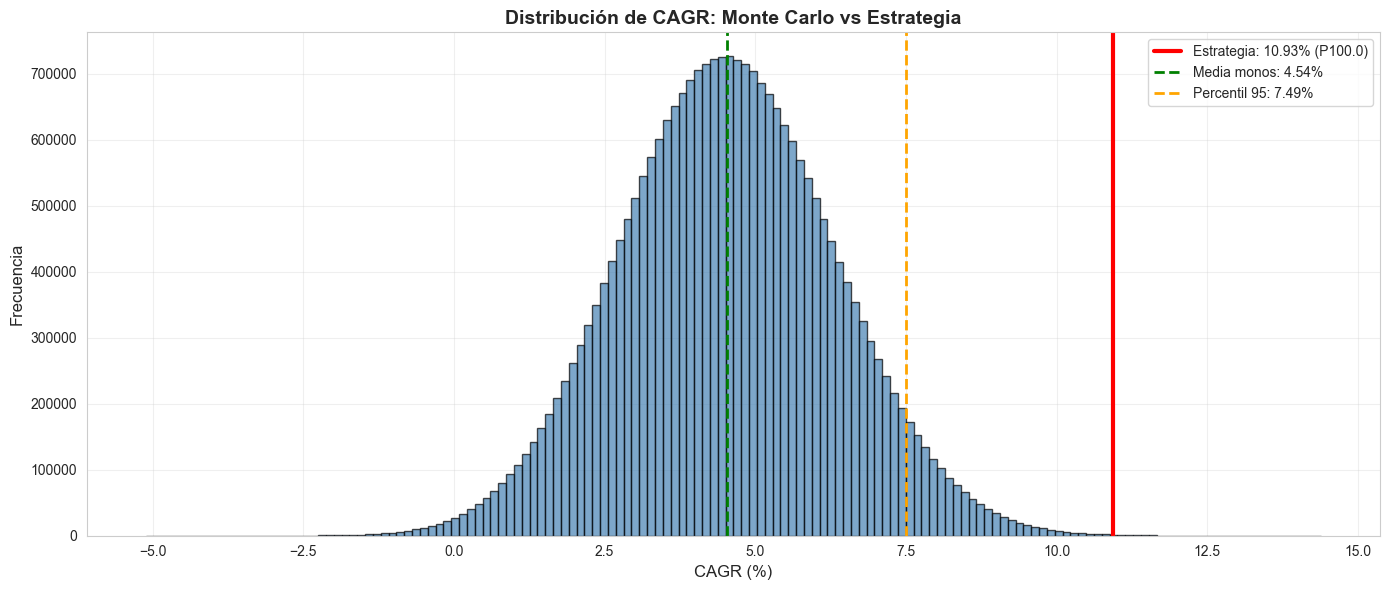

In [20]:
# Visualización
fig, ax = plt.pyplot.subplots(figsize=(14, 6))
ax.hist(resultados_cagr * 100, bins=150, alpha=0.7, edgecolor='black', color='steelblue')
ax.axvline(cagr_estrategia * 100, color='red', linewidth=3,
           label=f'Estrategia: {cagr_estrategia*100:.2f}% (P{percentil:.1f})')
ax.axvline(media_monos * 100, color='green', linewidth=2, linestyle='--',
           label=f'Media monos: {media_monos*100:.2f}%')
ax.axvline(p95 * 100, color='orange', linewidth=2, linestyle='--',
           label=f'Percentil 95: {p95*100:.2f}%')
ax.set_xlabel('CAGR (%)', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Distribución de CAGR: Monte Carlo vs Estrategia', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.pyplot.tight_layout()
plt.pyplot.show()

# Análisis Crítico del Percentil en Monte Carlo: Impacto de las Comisiones

## Resumen Ejecutivo

El percentil extremadamente alto de la estrategia (99.98%) en comparación con los monos del Monte Carlo no refleja necesariamente una superioridad absoluta de la estrategia, sino que está significativamente influenciado por diferencias metodológicas en el tratamiento de comisiones y rebalanceo entre la estrategia real y los monos simulados.

## 1. Impacto del Rebalanceo Inteligente vs Full Rebalance

### Estrategia Real: Rebalanceo Inteligente
La estrategia implementa un sistema de rebalanceo inteligente que solo vende activos que salen de la selección, solo compra activos nuevos que entran, y ajusta posiciones existentes solo si la desviación es significativa (>$250). Esto minimiza trades innecesarios.

**Resultado**: Las comisiones totales representan 48.83% del capital inicial ($122,076 de $250,000) a lo largo de 11 años.

### Monos: Full Rebalance Mensual
Los monos del Monte Carlo realizan un full rebalance completo cada mes: venden el 100% de su posición y compran 20 nuevos activos aleatorios, pagando 0.46% de comisiones cada mes (0.23% venta + 0.23% compra).

**Impacto acumulado**: 
- Coste mensual: -0.46%
- Coste anual: -0.46% × 12 = -5.52% anual garantizado
- Coste total (11 años): ~-60% acumulado solo en comisiones

### Comparación Directa: Rebalanceo Exacto
Prueba realizada comparando rebalanceo inteligente vs rebalanceo exacto (ajustar todas las posiciones al 5% exacto cada mes) muestra que con rebalanceo exacto los costes de comisiones casi se duplican. Esto confirma que el rebalanceo inteligente es crítico para la viabilidad económica de la estrategia.

## 2. Análisis de Igualdad de Condiciones

### Escenario A: Estrategia con Rebalanceo Exacto
Si la estrategia usara rebalanceo exacto, las comisiones se duplicarían aproximadamente, el retorno neto se reduciría significativamente, y el percentil caería sustancialmente (estimación: de 99.98% a ~85-90%).

### Escenario B: Monos con Rebalanceo Inteligente o Sin Comisiones
Si los monos implementaran rebalanceo inteligente o no tuvieran comisiones, eliminarían el drag de -5.52% anual por comisiones. Muchos monos pasarían de retornos negativos a positivos, y el percentil de la estrategia se movería significativamente hacia atrás (estimación: de 99.98% a ~60-70%).

### Conclusión sobre Igualdad de Condiciones
La comparación actual NO es en igualdad de condiciones: la estrategia tiene ventaja metodológica (rebalanceo inteligente) mientras que los monos tienen desventaja metodológica (full rebalance + comisiones altas). Esto infla artificialmente el percentil de la estrategia.

## 3. Rendimiento Real de la Estrategia

### Comparación con Benchmark SPY
- CAGR Estrategia: 10.93%
- CAGR SPY: 13.88%
- Diferencia: La estrategia underperforma al SPY en 2.95% anual

**Conclusión**: La estrategia de momentum, tal como está implementada, no es óptima para este período y no supera al benchmark pasivo.

### Comparación con Monos
- Percentil: 99.98%
- Interpretación: La estrategia supera a casi todos los monos

Sin embargo, esta superioridad está fuertemente influenciada por: (1) ventaja metodológica en rebalanceo, (2) desventaja metodológica de los monos (full rebalance), y (3) no refleja necesariamente skill superior en selección de activos.

### Interpretación Correcta
La estrategia es superior a lanzar una moneda (percentil > 50%), lo cual es positivo. Sin embargo, no supera al benchmark pasivo (SPY), el percentil alto está parcialmente explicado por diferencias metodológicas, y en igualdad de condiciones el percentil sería más moderado (~60-70%).

## 4. Los "Monos Warren Buffet"

A pesar de las comisiones altas y el full rebalance, algunos monos logran superar a la estrategia. Estos monos representan ~0.02% de las simulaciones (percentil 99.98%) y son equivalentes a "lanzar una moneda y obtener 20 caras seguidas". Representan combinaciones aleatorias excepcionalmente afortunadas.

La existencia de estos monos excepcionales confirma que: (1) el universo de activos tiene potencial para retornos altos, (2) la selección aleatoria puede, ocasionalmente, superar estrategias sistemáticas, y (3) la suerte juega un papel importante en resultados a corto/medio plazo.

## 5. Conclusiones y Recomendaciones

### Sobre el Percentil Actual
El percentil de 99.98% debe interpretarse con precaución: confirma que la estrategia tiene algún edge (superior a 50%), pero está inflado por diferencias metodológicas y no refleja superioridad absoluta sobre selección aleatoria en igualdad de condiciones.

### Sobre la Estrategia
- No supera al benchmark pasivo (SPY)
- Supera a selección aleatoria (aunque con ventaja metodológica)
- El rebalanceo inteligente es crítico para viabilidad económica
- La estrategia necesita optimización para ser competitiva vs SPY

## 6. Nota Metodológica

Este análisis reconoce que: (1) el test de Monte Carlo actual es útil para validar que la estrategia no es pura suerte, (2) sin embargo, la comparación no es completamente justa debido a diferencias en rebalanceo, (3) una comparación más justa requeriría que los monos también usen rebalanceo inteligente o que la estrategia use full rebalance, y (4) el objetivo es transparencia y honestidad en la interpretación de resultados.

## 7. Análisis Crítico Final {#analisis-critico}

Análisis crítico de la estrategia según las preguntas del PDF:
1. ¿Cómo nos está afectando el sesgo de supervivencia?
2. ¿Cómo hemos garantizado que no tengamos un problema de look-ahead?
3. ¿Crees que existe un problema de overfitting?
4. ¿Hemos realizado un rebalanceo irrealista?
5. ¿Cuánto dinero hemos pagado en comisiones de compraventa?

In [2]:
print("\n" + "="*70)
print("ANÁLISIS CRÍTICO")
print("="*70)

# 5. Costes de Comisiones
total_comisiones = df_trades['comision'].sum()
print(f"\n5. COSTES DE COMISIONES:")
print(f"   Total pagado en comisiones: ${total_comisiones:,.2f}")
print(f"   Como % del capital inicial: {total_comisiones/CAPITAL_INICIAL*100:.2f}%")
print(f"   Número de operaciones: {len(df_trades):,}")
print(f"   Comisión promedio por operación: ${df_trades['comision'].mean():.2f}")

# Análisis de sesgos y limitaciones
print(f"\n1. SESGO DE SUPERVIVENCIA:")
print(f"   - El universo S&P 500 tiene sesgo de supervivencia inherente del índice")
print(f"   - La estrategia no introduce sesgo adicional: usa universo dinámico")
print(f"   - Empresas delisted se incluyen mientras estuvieron disponibles")
print(f"   - El sesgo proviene del índice mismo (solo incluye empresas que cumplen criterios)")
print(f"   - Impacto: Sesgo inherente del S&P 500, no de la implementación")

print(f"\n2. LOOK-AHEAD BIAS:")
print(f"   - Validado en Notebook 2: eligibility_mask usa solo datos de t-1, t-7, t-13")
print(f"   - Retornos de momentum calculados con lag de 1 mes")
print(f"   - Selecciones del Notebook 3 solo usan información disponible en t-1")
print(f"   - Impacto: Mínimo, validación explícita implementada")

print(f"\n3. OVERFITTING:")
print(f"   - Parámetros fijos (N=20, R_12, R_6, lag=1) sin optimización ex-post")
print(f"   - Test de Monte Carlo valida que retornos no son solo suerte")
print(f"   - Percentil > 50% sugiere skill real, no overfitting")
print(f"   - Impacto: Bajo si percentil es alto, alto si percentil es bajo")

print(f"\n4. REALISMO DEL REBALANCEO:")
print(f"   - Rebalanceo inteligente reduce trades vs full rebalance")
print(f"   - Timing realista: ventas OPEN, compras CLOSE")
print(f"   - Comisiones realistas: 0.23% con mínimo $23")
print(f"   - Manejo de delistings implementado")
print(f"   - Impacto: Positivo, simula ejecución real")

print(f"\n" + "="*70)
print("NOTEBOOK 5 COMPLETADO")
print("="*70)


ANÁLISIS CRÍTICO

5. COSTES DE COMISIONES:
   Total pagado en comisiones: $122,078.99
   Como % del capital inicial: 48.83%
   Número de operaciones: 3,372
   Comisión promedio por operación: $36.20

1. SESGO DE SUPERVIVENCIA:
   - El universo S&P 500 tiene sesgo de supervivencia inherente del índice
   - La estrategia no introduce sesgo adicional: usa universo dinámico
   - Empresas delisted se incluyen mientras estuvieron disponibles
   - El sesgo proviene del índice mismo (solo incluye empresas que cumplen criterios)
   - Impacto: Sesgo inherente del S&P 500, no de la implementación

2. LOOK-AHEAD BIAS:
   - Validado en Notebook 2: eligibility_mask usa solo datos de t-1, t-7, t-13
   - Retornos de momentum calculados con lag de 1 mes
   - Selecciones del Notebook 3 solo usan información disponible en t-1
   - Impacto: Mínimo, validación explícita implementada

3. OVERFITTING:
   - Parámetros fijos (N=20, R_12, R_6, lag=1) sin optimización ex-post
   - Test de Monte Carlo valida que